# Imports and utility functions

In [2]:
data_dir = '/workspace'
import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

2025-04-10 09:35:07.303893: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 09:35:07.321389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744277707.342105    1650 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744277707.348413    1650 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744277707.364409    1650 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
def load_training_labels(data_dir='./', num_samples=None, balanced=False):
    training_labels = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'))
    training_labels['label'] = training_labels['label'].astype('bool')
    if num_samples is None:
        return training_labels.sample(frac=1).reset_index(drop=True)
    
    if balanced:
        pos = training_labels[training_labels['label']].sample(num_samples // 2)
        neg = training_labels[~training_labels['label']].sample(num_samples // 2)
        training_labels = pd.concat([pos, neg]).sample(frac=1).reset_index(drop=True)
    else:
        training_labels = training_labels.sample(num_samples).reset_index(drop=True)

    return training_labels


def get_training_images(training_labels, data_dir='./', color_mode='rgb', crop=1.0):
    images = np.array(
        [tf.image.central_crop(
            keras.utils.img_to_array(keras.utils.load_img(os.path.join(data_dir, 'train', f'{id}.tif'), color_mode=color_mode)),
            crop).numpy()
         for id in training_labels['id']])
    return images


def batch_image_generator(training_labels, batch_size):
    inp = list(training_labels.index)
    while True:
        random.shuffle(inp)
        for i in range(0, len(inp), batch_size):
            inds = inp[i:i+batch_size]
            batch_labels = training_labels.loc[inds].reset_index(drop=True)
            batch_images = get_training_images(batch_labels)
            yield batch_images, batch_labels['label']


def stochastic_batch_image_generator(training_labels, batch_size):
    while True:
        batch_labels = training_labels.sample(batch_size).reset_index(drop=True)
        ids = batch_labels['id']
        batch_images = get_training_images(batch_labels)
        yield batch_images, batch_labels['label']


def get_test_images(data_dir='./', color_mode='rgb', crop=1.0):
    test_image_files = [f for f in os.listdir(os.path.join(data_dir, "test")) if f.endswith(".tif")]
    test_ids = [Path(f).stem for f in test_image_files]
    test_images = np.array(
        [tf.image.central_crop(
            keras.utils.img_to_array(keras.utils.load_img(os.path.join(data_dir, 'test', f), color_mode=color_mode)),
            crop).numpy()
         for f in test_image_files])
    return test_images, test_ids


def generate_submission(model, test_images, test_ids, color_mode='rgb', output_file='submission.csv'):
    test_predictions = model.predict(test_images)
    submission = pd.DataFrame({"id": test_ids, "label": test_predictions.flatten()})
    submission.to_csv(output_file, index=False)


def plot_training_history(history):
    # Plot the training and validation loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

# Problem Description

The challenge is to build CNN models to identify whether there are cancer cells in small image patches taken from larger pathology scans. The images in the dataset are 96x96 pixels in size with 3 color channels and are taken from the PCam dataset. The dataset is from the kaggle competition https://www.kaggle.com/competitions/histopathologic-cancer-detection and the task is to identify whether there is atleast one pixel of tumor tissue in the center 32x32 pixels of the image.

There are 220,025 training images and 57,458 test images. The training images are labeled as 0 or 1, where 0 indicates no tumor pixels and 1 indicates atleast one tumor pixel. The test images are unlabeled.




# Exploratory Data Analysis (EDA)


In [4]:
# Read the training labels
training_labels = load_training_labels(data_dir)
print(training_labels.shape)
print(training_labels.head())
print(training_labels['label'].value_counts())


(220025, 2)
                                         id  label
0  e3570f381a41738432150d2e69344abc6dbde1a9   True
1  9993e00c0de0980a2aadd408911aa149bf777d10  False
2  9ec63deb69dd623262b672d4568890ebc769470d  False
3  6ab34f996aa4f093edbfa5639f7447f087b3bff6   True
4  e04c5f9913412777eecc3ef56745be70de19f151  False
label
False    130908
True      89117
Name: count, dtype: int64


From the above output, we can see that the training data has 130908 images without tumor tissue and 89117 images with tumor tissue. The dataset is slightly imbalanced.


Visualizing a few sample images from the training dataset. 

I0000 00:00:1744277784.291157    1650 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79091 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:51:00.0, compute capability: 8.0


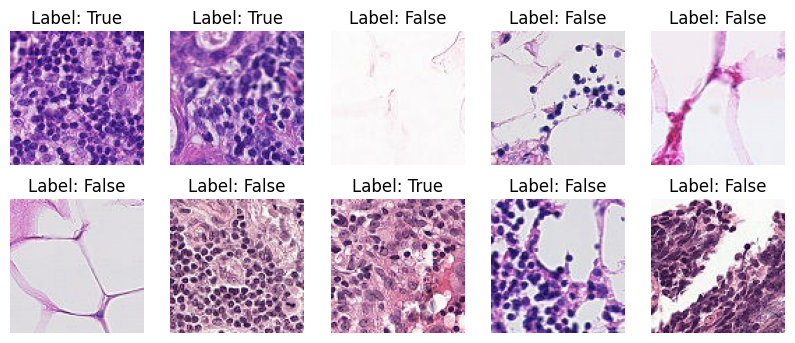

In [5]:
sample_training_labels = training_labels.sample(10)
sample_images = get_training_images(sample_training_labels, data_dir)
sample_labels = sample_training_labels['label']

plt.figure(figsize=(10, 4))
for image, label, i in zip(sample_images, sample_labels, range(len(sample_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

Since the problem is to look at tumor tissues in the center 32x32 pixels of the image, let's crop and visualize the center of the images

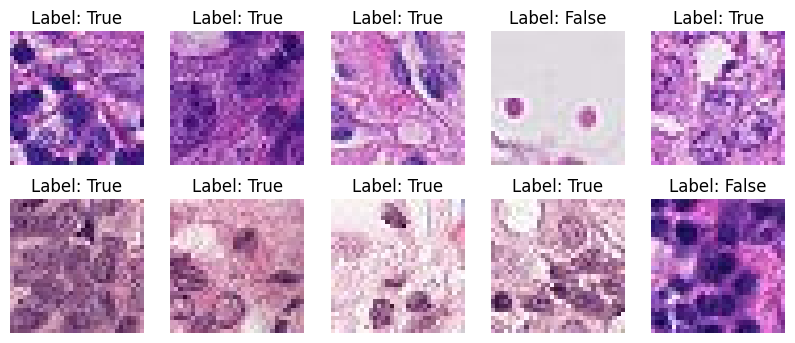

In [ ]:
cropped_images = get_training_images(sample_training_labels, data_dir, crop=1/3)
plt.figure(figsize=(10, 4))
for image, label, i in zip(cropped_images, sample_labels, range(len(cropped_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

Also looking at a few images in greyscaleale both the full images and the cropped 32x32 center patches.

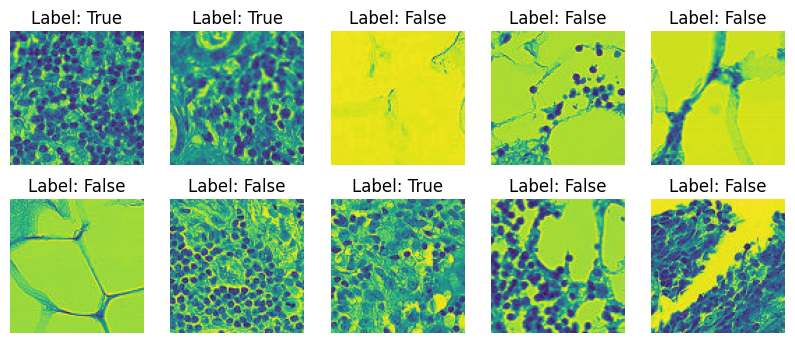

In [6]:
sample_images = get_training_images(sample_training_labels, data_dir, color_mode='grayscale')
sample_labels = sample_training_labels['label']
plt.figure(figsize=(10, 4))
for image, label, i in zip(sample_images, sample_labels, range(len(sample_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()




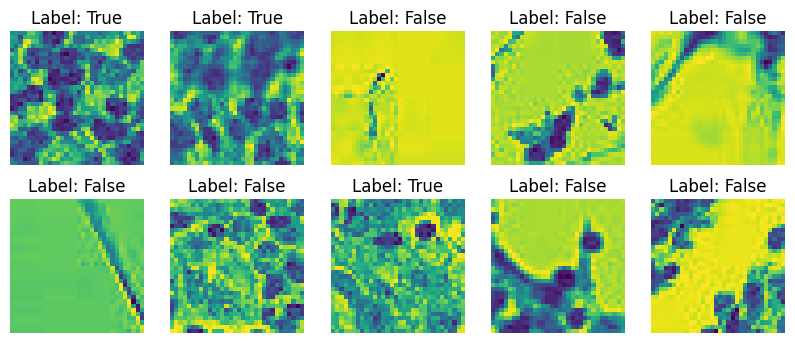

In [7]:
cropped_images = get_training_images(sample_training_labels, data_dir, color_mode='grayscale', crop=1/3)

plt.figure(figsize=(10, 4))
for image, label, i in zip(cropped_images, sample_labels, range(len(sample_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

The plan is to train CNN based models on the 32x32 center patches with color information and also on just the grayscale images. We will compare the results of the two models to see whether color information is useful for this task.  
I also plan to try a few different model architectures to see which one performs the best.
Also I am planning to use different crops to see whether using a bigger than 32x32 center crop provides any improvement.

### TODO
Add more visualizations and data analysis

# Model building and tuning

Preparing training and test data. I will start with 32x32 center crops and going to use the color information.

In [8]:
# Prepare the training data
X = get_training_images(training_labels, data_dir, crop=1/3)
y = training_labels['label'].values

print(X.shape)
print(y.shape)


(220025, 32, 32, 3)
(220025,)


In [9]:
test_images, test_ids = get_test_images(data_dir, crop=1/3)
print(test_images.shape)

(57458, 32, 32, 3)


In [10]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X, y, test_size=0.25, random_state=77)

print(X.shape)
print(y.shape)

print(X_test.shape)
print(y_test.shape)

(165018, 32, 32, 3)
(165018,)
(55007, 32, 32, 3)
(55007,)


Below is a little helper function to train a model and generate submission file. I am going to create a few models, execute them and compare the results.

In [45]:
def train_model_and_generate_submission(model, model_name, epochs=100, batch_size=32, validation_split=0.2, generate=True):
    checkpointer = keras.callbacks.ModelCheckpoint(
        f'{model_name}.best_weights.keras', 
        save_best_only=True,
        verbose=1,
        monitor='val_AUC',
        mode='max')
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        verbose=1,
        monitor='val_AUC',
        mode='max')

    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, 
                        callbacks=[checkpointer, early_stopping])
    
    model.load_weights(f'{model_name}.best_weights.keras')
    if generate:
        generate_submission(model, test_images, test_ids, output_file=f'submission_{model_name}.csv')
    return model, history
    

I will start with a simple CNN based model with one fully connected layer at the end for classification. 

For the first model, I will use a few groups with a convolution layers and a pooling layer followed by a single fully connected hidden layer for classification. 
The convolution layers will do the feature extraction and then the final FC hidden layer will do the classification.
I will use sigmoid for the output layer since this is a binary classification problem and ReLU activation for all the other layers.
I am using binary crossentropy as the loss function and ADAM as the optimizer. I am tracking AUC as this competition uses AUC (Area Under the Curve) for scoring.

In [12]:
model1 = keras.Sequential([
    layers.InputLayer(shape=(32, 32, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,673 (1.36 MB)

 Trainable params: 356,673 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model1, history = train_model_and_generate_submission(model1, 'cnn_cancer_detection_model1')

Epoch 1/100


I0000 00:00:1744278937.773840    1991 service.cc:152] XLA service 0x77554000d920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744278937.773900    1991 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-04-10 09:55:37.869670: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744278938.161005    1991 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-10 09:55:42.219703: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_712', 16 bytes spill stores, 16 bytes spill loads

2025-04-10 09:55:42.221970: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_379', 32

4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8008 - accuracy: 0.7466 - loss: 0.5270 
Epoch 1: val_AUC improved from -inf to 0.85416, saving model to cnn_cancer_detection_model1.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - AUC: 0.8008 - accuracy: 0.7466 - loss: 0.5270 - val_AUC: 0.8542 - val_accuracy: 0.7890 - val_loss: 0.4613
Epoch 2/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8528 - accuracy: 0.7908 - loss: 0.4637 
Epoch 2: val_AUC improved from 0.85416 to 0.86821, saving model to cnn_cancer_detection_model1.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - AUC: 0.8528 - accuracy: 0.7908 - loss: 0.4637 - val_AUC: 0.8682 - val_accuracy: 0.7918 - val_loss: 0.4584
Epoch 3/100
4117/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8675 - accuracy: 0.8012 - loss: 0.4422 
Epoch 3: val_AUC improved from 0.86821 to 0.86947, saving model to cnn_cancer_detection_model1.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - AUC: 0.8675

2025-04-10 10:03:11.331981: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 36 bytes spill stores, 36 bytes spill loads

2025-04-10 10:03:11.464563: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 188 bytes spill stores, 188 bytes spill loads

2025-04-10 10:03:11.608358: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 268 bytes spill stores, 328 bytes spill loads



1796/1796 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


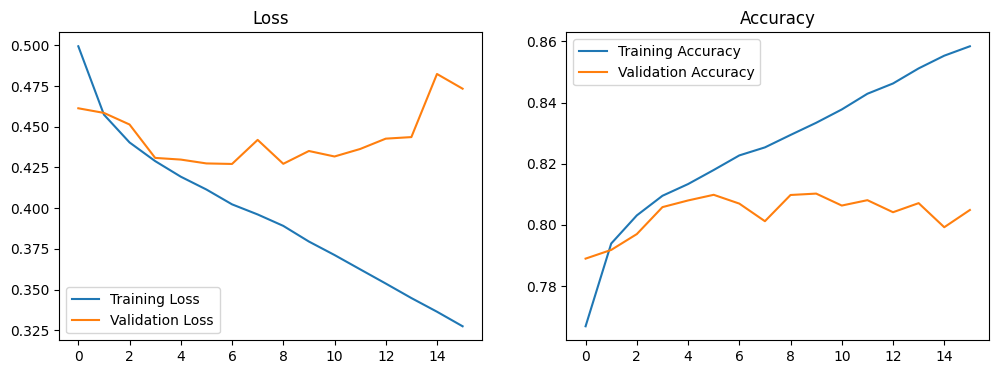

In [14]:
plot_training_history(history)

In [15]:
print(model1.evaluate(X_test, y_test))

1717/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8845 - accuracy: 0.8099 - loss: 0.4213

2025-04-10 10:05:35.738650: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 36 bytes spill stores, 36 bytes spill loads

2025-04-10 10:05:35.761907: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 188 bytes spill stores, 188 bytes spill loads

2025-04-10 10:05:35.802689: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 268 bytes spill stores, 328 bytes spill loads



1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - AUC: 0.8845 - accuracy: 0.8099 - loss: 0.4213
[0.4223170876502991, 0.8829081654548645, 0.810442328453064]


I got an accuracy of 0.81 on the test data and an AUC score of 0.88.  
On kaggle, I got a private score of 0.8257 and a public score of 0.8673 (Kaggle is using AUC) for this model.

Now going ahead with a more complicated model with 1 more convolution block and using BatchNormalization. Also applying padding before applying convolution.

In [17]:
model2 = keras.Sequential([
    layers.InputLayer(input_shape=(32, 32, 3)),
    layers.Rescaling(1. / 255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,445,057 (5.51 MB)

 Trainable params: 1,442,049 (5.50 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [18]:
model2, history = train_model_and_generate_submission(model2, 'cnn_cancer_detection_model2')

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8283 - accuracy: 0.7706 - loss: 0.5177 
Epoch 1: val_AUC improved from -inf to 0.88264, saving model to cnn_cancer_detection_model2.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - AUC: 0.8283 - accuracy: 0.7706 - loss: 0.5177 - val_AUC: 0.8826 - val_accuracy: 0.8118 - val_loss: 0.4421
Epoch 2/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8777 - accuracy: 0.8110 - loss: 0.4275 
Epoch 2: val_AUC did not improve from 0.88264
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - AUC: 0.8777 - accuracy: 0.8110 - loss: 0.4275 - val_AUC: 0.8641 - val_accuracy: 0.7694 - val_loss: 0.5247
Epoch 3/100
4120/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8973 - accuracy: 0.8299 - loss: 0.3926 
Epoch 3: val_AUC improved from 0.88264 to 0.89301, saving model to cnn_cancer_detection_model2.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - AUC: 0.8973 - accuracy: 0.8299 - loss: 0.3926 - val_AUC: 0.8930 - v

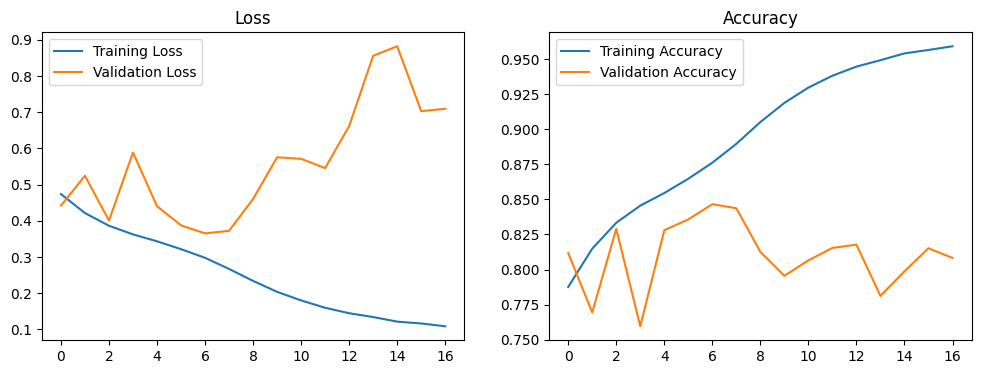

In [19]:
plot_training_history(history)

In [20]:
print(model2.evaluate(X_test, y_test))

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - AUC: 0.9221 - accuracy: 0.8489 - loss: 0.3586
[0.36176252365112305, 0.9210634827613831, 0.8480193614959717]


This model had an accuracy of 0.85 on my split test data and an AUC of 0.9221.
On kaggle, this model had a private score of 0.8512 and a public score of 0.8925.  
All of these are noticeable improvements over model1.

Now going for a model with 2 convolution layers in each convolution block. I am going to use Dropout normalization for the fully-connected layer. 
Also I am lowering the learning_rate parameter for the Adam optimizer as this complicated model is getting stuck in a local optimum with the default learning parameters where it predicts negative for everything (as there are more negatives than positives in the training set).

In [24]:
model3 = keras.Sequential([
    layers.InputLayer(input_shape=(32, 32, 3)),
    layers.Rescaling(1. / 255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(48, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(48, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),    
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')
])

model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
               loss=keras.losses.BinaryCrossentropy(),
               metrics=['AUC', 'accuracy'])
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 48)     │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,667,425 (6.36 MB)

 Trainable params: 1,667,425 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model3, history = train_model_and_generate_submission(model3, 'cnn_cancer_detection_model3')

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8047 - accuracy: 0.7449 - loss: 0.5209
Epoch 1: val_AUC improved from -inf to 0.84543, saving model to cnn_cancer_detection_model3.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 52s 11ms/step - AUC: 0.8047 - accuracy: 0.7449 - loss: 0.5209 - val_AUC: 0.8454 - val_accuracy: 0.7689 - val_loss: 0.4812
Epoch 2/100
4123/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8649 - accuracy: 0.7978 - loss: 0.4456 
Epoch 2: val_AUC improved from 0.84543 to 0.87704, saving model to cnn_cancer_detection_model3.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - AUC: 0.8649 - accuracy: 0.7978 - loss: 0.4456 - val_AUC: 0.8770 - val_accuracy: 0.7980 - val_loss: 0.4484
Epoch 3/100
4121/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8800 - accuracy: 0.8110 - loss: 0.4222  
Epoch 3: val_AUC improved from 0.87704 to 0.88986, saving model to cnn_cancer_detection_model3.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step

In [26]:
print(model3.evaluate(X_test, y_test))

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.9247 - accuracy: 0.8509 - loss: 0.3388
[0.34124577045440674, 0.9236354827880859, 0.8499645590782166]


I got an accuracy of 0.85 and an AUC of 0.923 on my split test data which is a very tiny improvement over model2.
On kaggle, this model got a private score of 0.8755 and 0.8971. The private score is a noticeable improvement over 
the previous model. 

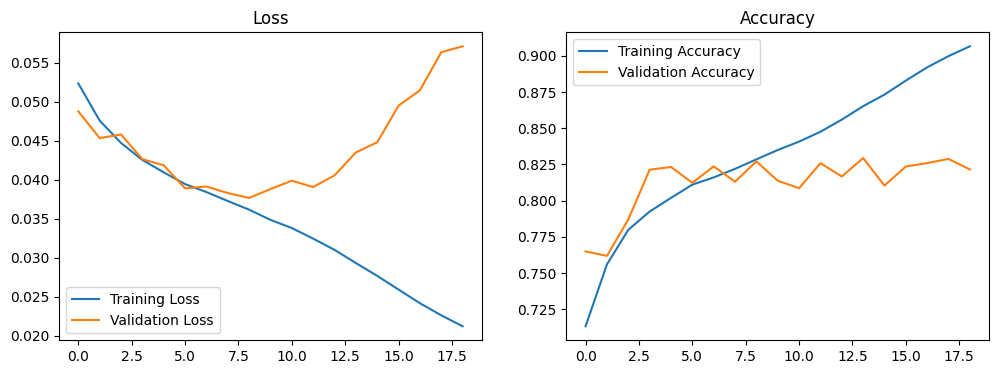

In [47]:
plot_training_history(history)

Trying grayscale images to see if there is any improvement. I will start out with model2 as model3 is only a very small improvement over it for a lot of additional complexity.


In [27]:
# Prepare the training data
X = get_training_images(training_labels, data_dir, crop=1/3, color_mode='grayscale')
y = training_labels['label'].values

print(X.shape)
print(y.shape)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.25, random_state=77)

print(X.shape)
print(y.shape)

print(X_test.shape)
print(y_test.shape)


(220025, 32, 32, 1)
(220025,)
(165018, 32, 32, 1)
(165018,)
(55007, 32, 32, 1)
(55007,)


In [28]:
model2 = keras.Sequential([
    layers.InputLayer(shape=(32, 32, 1)),
    layers.Rescaling(1. / 255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', 'accuracy'])
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,444,481 (5.51 MB)

 Trainable params: 1,441,473 (5.50 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [30]:
model2, history = train_model_and_generate_submission(model2, 'cnn_cancer_detection_model2_grayscale', generate=False)

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8050 - accuracy: 0.7513 - loss: 0.5476 
Epoch 1: val_AUC improved from -inf to 0.81518, saving model to cnn_cancer_detection_model2_grayscale.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - AUC: 0.8050 - accuracy: 0.7513 - loss: 0.5476 - val_AUC: 0.8152 - val_accuracy: 0.7112 - val_loss: 0.6176
Epoch 2/100
4125/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8413 - accuracy: 0.7798 - loss: 0.4826 
Epoch 2: val_AUC improved from 0.81518 to 0.85478, saving model to cnn_cancer_detection_model2_grayscale.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - AUC: 0.8413 - accuracy: 0.7798 - loss: 0.4826 - val_AUC: 0.8548 - val_accuracy: 0.7857 - val_loss: 0.4928
Epoch 3/100
4123/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8633 - accuracy: 0.7978 - loss: 0.4499 
Epoch 3: val_AUC improved from 0.85478 to 0.86048, saving model to cnn_cancer_detection_model2_grayscale.best_weights.keras
4126/4126 ━━━━━

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_23" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (32, 32, 32, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 32, 32, 3), dtype=float32)
  • training=False
  • mask=None

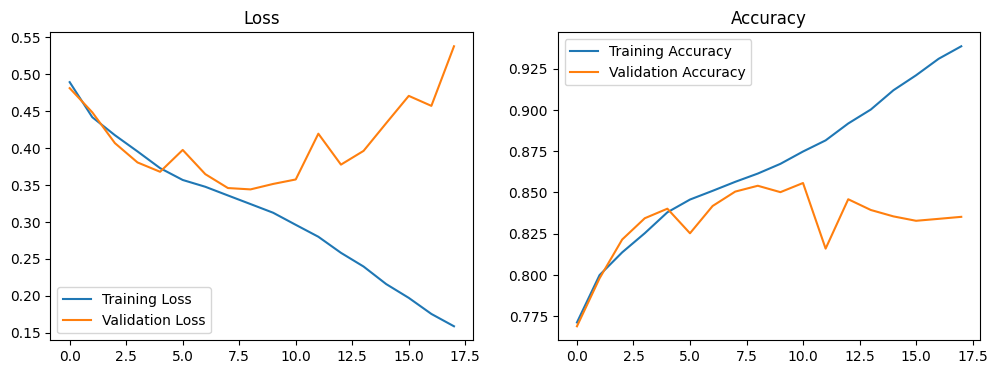

In [31]:
plot_training_history(history)

In [32]:
print(model2.evaluate(X_test, y_test))

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8743 - accuracy: 0.8030 - loss: 0.4345
[0.43552765250205994, 0.8736843466758728, 0.801716148853302]


Now trying model2 with larger (48x48) crop instead of 32x32 to see if there is going to be any improvement.

In [34]:
# Prepare the training data
X = get_training_images(training_labels, data_dir, crop=1/2)
y = training_labels['label'].values

print(X.shape)
print(y.shape)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.25, random_state=77)

print(X.shape)
print(y.shape)

print(X_test.shape)
print(y_test.shape)

(220025, 48, 48, 3)
(220025,)
(165018, 48, 48, 3)
(165018,)
(55007, 48, 48, 3)
(55007,)


In [80]:
model2 = keras.Sequential([
    layers.InputLayer(shape=(48, 48, 3)),
    #layers.Rescaling(1. / 255),
    layers.Conv2D(48, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(96, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(192, 3, activation='relu'),
    layers.MaxPooling2D(),
    #layers.Conv2D(384, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.BinaryCrossentropy(), metrics=['AUC', 'accuracy'])
model2.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_81 (Conv2D)              │ (None, 46, 46, 48)     │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 23, 23, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 23, 23, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 21, 21, 96)     │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 10, 10, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 10, 10, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 8, 8, 192)      │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,356,769 (12.81 MB)

 Trainable params: 3,356,769 (12.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2, history = train_model_and_generate_submission(model2, 'cnn_cancer_detection_model2_48_dropout5', generate=True)

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.6999 - accuracy: 0.6794 - loss: 2.2565  
Epoch 1: val_AUC improved from -inf to 0.83512, saving model to cnn_cancer_detection_model2_48_dropout5.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - AUC: 0.6999 - accuracy: 0.6794 - loss: 2.2562 - val_AUC: 0.8351 - val_accuracy: 0.6853 - val_loss: 0.5879
Epoch 2/100
4122/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8353 - accuracy: 0.7724 - loss: 0.4924 
Epoch 2: val_AUC improved from 0.83512 to 0.85786, saving model to cnn_cancer_detection_model2_48_dropout5.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - AUC: 0.8353 - accuracy: 0.7724 - loss: 0.4924 - val_AUC: 0.8579 - val_accuracy: 0.7856 - val_loss: 0.4831
Epoch 3/100
4123/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8599 - accuracy: 0.7936 - loss: 0.4565 
Epoch 3: val_AUC improved from 0.85786 to 0.89341, saving model to cnn_cancer_detection_model2_48_dropout5.best_weights.keras
4126/412

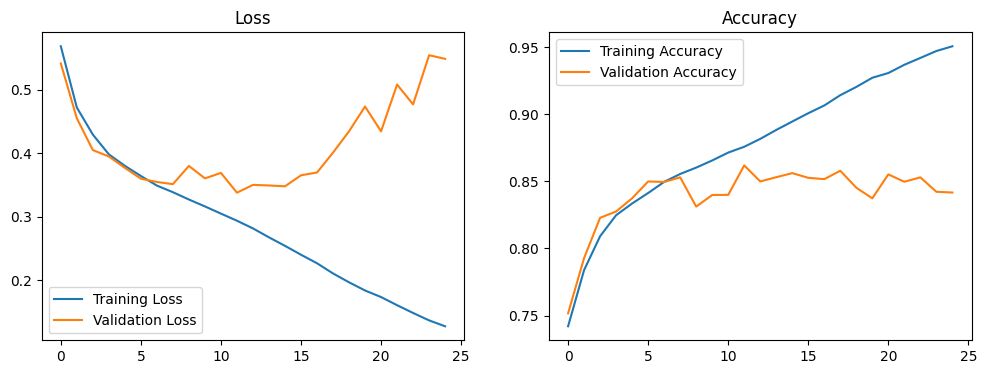

In [78]:
plot_training_history(history)

In [79]:
print(model2.evaluate(X_test, y_test))

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.9296 - accuracy: 0.8584 - loss: 0.3447
[0.3487989902496338, 0.9282422065734863, 0.8568363785743713]


In [40]:
test_images, test_ids = get_test_images(data_dir, crop=1/2)
print(test_images.shape)

(57458, 48, 48, 3)


In [41]:
generate_submission(model2, test_images, test_ids, output_file=f'submission_cnn_cancer_detection_model2_48.csv')

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


In [42]:
model3 = keras.Sequential([
    layers.InputLayer(input_shape=(48, 48, 3)),
    layers.Rescaling(1. / 255),
    layers.Conv2D(48, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(96, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(96, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),    
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')
])

model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
               loss=keras.losses.BinaryFocalCrossentropy(),
               metrics=['AUC', 'accuracy'])
model3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 48, 48, 48)     │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 48, 48, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 24, 24, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 12, 12, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 12, 12, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 12, 12, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,119,233 (11.90 MB)

 Trainable params: 3,119,233 (11.90 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model3, history = train_model_and_generate_submission(model3, 'cnn_cancer_detection_model3_48')

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.8247 - accuracy: 0.7608 - loss: 0.1282 
Epoch 1: val_AUC improved from -inf to 0.89336, saving model to cnn_cancer_detection_model3_48.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 122s 28ms/step - AUC: 0.8247 - accuracy: 0.7608 - loss: 0.1282 - val_AUC: 0.8934 - val_accuracy: 0.8230 - val_loss: 0.1047
Epoch 2/100
4123/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.8957 - accuracy: 0.8235 - loss: 0.1034 
Epoch 2: val_AUC improved from 0.89336 to 0.91492, saving model to cnn_cancer_detection_model3_48.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 56s 14ms/step - AUC: 0.8957 - accuracy: 0.8235 - loss: 0.1034 - val_AUC: 0.9149 - val_accuracy: 0.8414 - val_loss: 0.0951
Epoch 3/100
4124/4126 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.9172 - accuracy: 0.8455 - loss: 0.0931 
Epoch 3: val_AUC improved from 0.91492 to 0.93016, saving model to cnn_cancer_detection_model3_48.best_weights.keras
4126/4126 ━━━━━━━━━━━━━━━━━━━━

TypeError: 'bool' object is not callable

In [44]:
generate_submission(model3, test_images, test_ids, output_file=f'submission_cnn_cancer_detection_model3_48.csv')

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


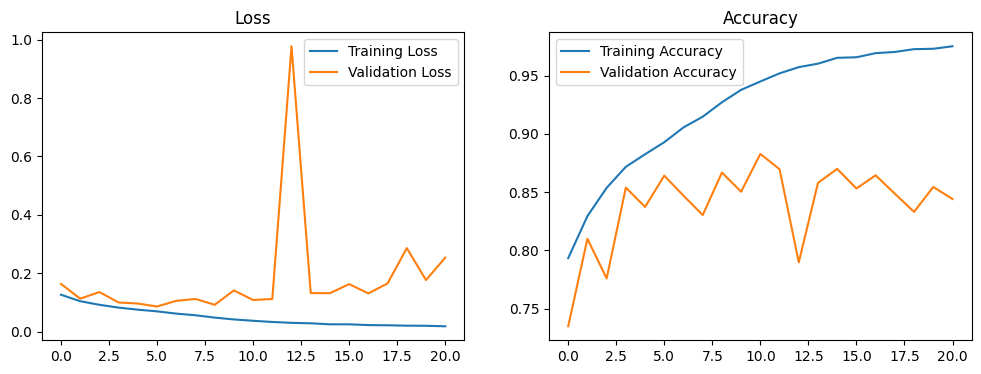

In [48]:
plot_training_history(history)

In [49]:
print(model3.evaluate(X_test, y_test))

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.9545 - accuracy: 0.8883 - loss: 0.0741
[0.07425835728645325, 0.9544018507003784, 0.8896504044532776]


# Results and Analysis

# Conclusion